# Descriptives Notebook: Initial Analysis for H1B Project March 2025

In [118]:
# Imports and Paths
root = "/Users/amykim/Princeton Dropbox/Amy Kim/h1bworkers"
code = "/Users/amykim/Documents/GitHub/h1bworkers/code"

import duckdb as ddb
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import employer_merge_helpers as emh
import analysis_helpers as ah
import statsmodels.formula.api as smf

con = ddb.connect()

# creating sql functions
con.create_function("get_fiscal_year", ah.get_fiscal_year_sql, ["VARCHAR"], "VARCHAR")

con.create_function("get_fiscal_year_foia", ah.get_fiscal_year_foia_sql, ["VARCHAR"], "FLOAT")
    
con.create_function("get_quarter", ah.get_quarter_sql, ["VARCHAR"], "FLOAT")

con.create_function("get_quarter_foia", ah.get_quarter_foia_sql, ["VARCHAR"], "FLOAT")

# importing data
## duplicate rcids (companies that appear more than once in linkedin data)
dup_rcids = con.read_csv(f"{root}/data/int/dup_rcids_mar20.csv")

## matched company data from R
rmerge = con.read_csv(f"{root}/data/int/good_match_ids_mar20.csv")

## raw FOIA bloomberg data
foia_raw_file = con.read_csv(f"{root}/data/raw/foia_bloomberg/foia_bloomberg_all.csv")

## joining raw FOIA data with merged data to get foia_ids in raw foia data
foia_with_ids = con.sql("SELECT *, CASE WHEN matched IS NULL THEN 0 ELSE matched END AS matchind FROM ((SELECT * FROM foia_raw_file WHERE NOT FEIN = '(b)(3) (b)(6) (b)(7)(c)') AS a LEFT JOIN (SELECT lottery_year, FEIN, foia_id, 1 AS matched FROM rmerge GROUP BY lottery_year, FEIN, foia_id) AS b ON a.lottery_year = b.lottery_year AND a.FEIN = b.FEIN)")

# collapsing FOIA raw data to foia_id level
foia_for_merge = con.sql("""
SELECT foia_id, FIRST(employer_name) AS company_FOIA, lottery_year, 
    MAX(CASE WHEN NOT NUM_OF_EMP_IN_US = 'NA' THEN NUM_OF_EMP_IN_US::INTEGER END) AS n_us_employees,
    COUNT(*) AS n_apps_tot,
    COUNT(CASE WHEN ben_multi_reg_ind = 0 THEN 1 END) AS n_apps, 
    COUNT(CASE WHEN status_type = 'SELECTED' THEN 1 END) AS n_success_tot,
    COUNT(CASE WHEN status_type = 'SELECTED' AND ben_multi_reg_ind = 0 THEN 1 END) AS n_success,
    COUNT(CASE WHEN status_type = 'SELECTED' AND ben_multi_reg_ind = 0 AND rec_date != 'NA' THEN 1 END) AS n_i129
FROM foia_with_ids WHERE foia_id IS NOT NULL GROUP BY foia_id, lottery_year
""").df()

## revelio data (pre-filtered to only companies in rmerge)
merged_pos = con.read_parquet(f"{root}/data/int/rev_merge_mar20.parquet")

## pre-processed data
merged_for_analysis = con.read_parquet(f"{root}/data/int/merged_for_analysis_mar25.parquet")
balanced_full = con.read_parquet(f"{root}/data/int/balanced_full_mar25.parquet")



## FOIA Descriptives

In [13]:
# Sankey
import plotly.graph_objs as go


rawdf = foia_raw_file.df()

# get counts
n0 = rawdf.shape[0]
n1 = rawdf.loc[rawdf['status_type']=="SELECTED"].shape[0]
n3 = rawdf.loc[rawdf['status_type']=="(b)(3) (b)(6) (b)(7)(c)"].shape[0]
n2 = n0-n1-n3

n4 = rawdf.loc[rawdf['rec_date']!='NA'].shape[0]
n5 = rawdf.loc[rawdf['FIRST_DECISION'] == "Approved"].shape[0]
n6 = rawdf.loc[rawdf['FIRST_DECISION'] == "Denied"].shape[0]
n7 = n4-n5-n6 

# Nodes & links (todo: add pre-nodes by year?)
node_names = [f'All Lott. Apps (1.8m)',
              'Lott. Winners (32%)',
              'Lottery Losers (68%)',
              'Data Censored',
              'Submit I-129 (66% of winners)',
              'I-129 Approved (97% of submissions)',
              'I-129 Denied',
              'I-129 No Decision']
nodes = [['ID', 'Label', 'Color'],
        [0,'All Lottery Applications','gray'],
        [1,'Lottery Winners','green'],
        [2,'Lottery Losers','red'],
        [3, 'Data Censored','black'],
        [4,'Submit I-129','gray'],
        [5,'I-129 Approved','green'],
        [6,'I-129 Denied','red']]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = node_names,
      color = ['gray','green','red','black','gray','green','red','black']
    ),
    link = dict(
      source = [0,0,0,1,4,4,4], 
      target = [2,1,3,4,5,6,7],
      value = [n2,n1,n3,n4,n5,n6,n7]
  ))])

fig.update_layout(title_text="H-1B Lottery Applications FY2021-2024", font_size=10)
fig.show()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[Text(0.5, 0, 'Number of H1B Lottery Applications'),
 Text(0, 0.5, 'Number of Firm x Lottery Years')]

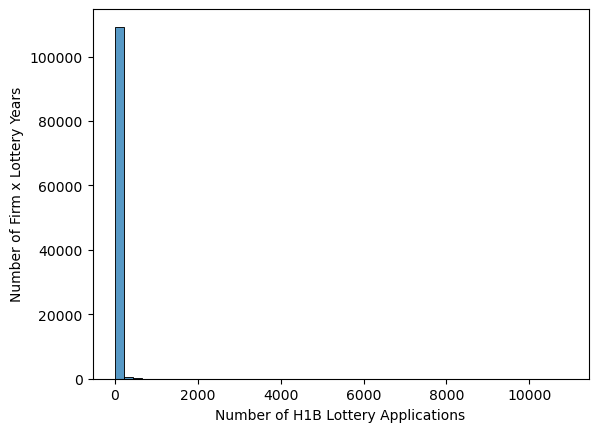

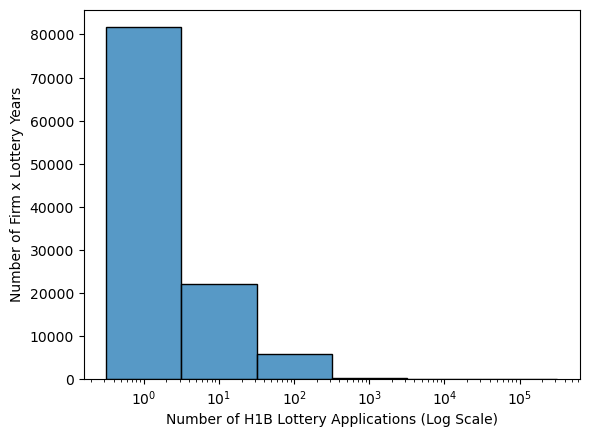

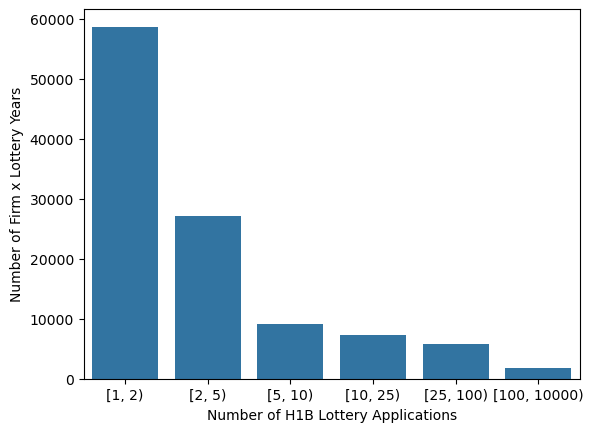

In [14]:
# employer-level app histogram
foia_for_merge['n_apps_binned'] = pd.cut(foia_for_merge['n_apps_tot'], bins = [1,2,5,10,25,100,10000], right = False)

# All H1B Applications 
## raw
sns.histplot(data = foia_for_merge, x = 'n_apps_tot', bins = 50).set(xlabel = "Number of H1B Lottery Applications", ylabel = "Number of Firm x Lottery Years")

## log scale
plt.figure()
sns.histplot(data = foia_for_merge, x = 'n_apps_tot', bins = 50, discrete = True, log_scale=True).set(xlabel = "Number of H1B Lottery Applications (Log Scale)", ylabel = "Number of Firm x Lottery Years")

## discrete
plt.figure()
sns.countplot(x = 'n_apps_binned', data = foia_for_merge).set(xlabel = "Number of H1B Lottery Applications", ylabel = "Number of Firm x Lottery Years")



In [119]:
# IDing outsourcing/staffing companies
foia_main_samp_unfilt = con.sql("SELECT FEIN, lottery_year, COUNT(CASE WHEN ben_multi_reg_ind = 1 THEN 1 END)/COUNT(*) AS share_multireg, COUNT(*) AS n_apps_tot, COUNT(CASE WHEN status_type = 'SELECTED' THEN 1 END) AS n_success, COUNT(CASE WHEN status_type = 'SELECTED' THEN 1 END)/COUNT(*) AS win_rate FROM foia_with_ids GROUP BY FEIN, lottery_year")

n = con.sql('SELECT COUNT(*) FROM foia_main_samp_unfilt').df().iloc[0,0]
print(f"Total Employer x Years: {n}")
print(f"Employer x Years with Fewer than 50 Apps: {con.sql("SELECT COUNT(*) FROM foia_main_samp_unfilt WHERE n_apps_tot < 50").df().iloc[0,0]}")
print(f"Employer x Years with Fewer than 50% Duplicates: {con.sql("SELECT COUNT(*) FROM foia_main_samp_unfilt WHERE share_multireg < 0.5").df().iloc[0,0]}")

foia_main_samp = con.sql("SELECT * FROM foia_main_samp_unfilt WHERE n_apps_tot < 50 AND share_multireg < 0.5")
print(f"Preferred Sample: {foia_main_samp.df().shape[0]} ({round(100*foia_main_samp.df().shape[0]/n)}%)")

foia_main_samp_def = con.sql("SELECT *, CASE WHEN n_apps_tot < 50 AND share_multireg < 0.5 THEN 'insamp' ELSE 'outsamp' END AS sampgroup FROM foia_main_samp_unfilt")
con.sql("SELECT sampgroup, SUM(n_success)/SUM(n_apps_tot) AS total_win_rate FROM foia_main_samp_def GROUP BY sampgroup")

Total Employer x Years: 172068
Employer x Years with Fewer than 50 Apps: 165981
Employer x Years with Fewer than 50% Duplicates: 140222
Preferred Sample: 138047 (80%)


┌───────────┬────────────────────┐
│ sampgroup │   total_win_rate   │
│  varchar  │       double       │
├───────────┼────────────────────┤
│ outsamp   │ 0.3023793501074909 │
│ insamp    │ 0.3644218504138618 │
└───────────┴────────────────────┘

In [120]:
foia_df = con.sql("SELECT * FROM ((SELECT FEIN, lottery_year, sampgroup FROM foia_main_samp_def) AS a JOIN foia_with_ids AS b ON a.FEIN = b.FEIN AND a.lottery_year = b.lottery_year)").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [17]:
foia_df.groupby('sampgroup').size()

sampgroup
insamp      429612
outsamp    1374535
dtype: int64

In [124]:
# summary stats table: winners vs losers
foia_df['win'] = foia_df['status_type'] == "SELECTED"
foia_df['india'] = foia_df['country_of_birth'] == "IND"
foia_df['china'] = foia_df['country_of_birth'] == "CHN"
foia_df['female'] = foia_df['gender'] == "female"
foia_df['app_age'] = foia_df['lottery_year'].apply(int)-1-foia_df['ben_year_of_birth'].apply(int)

sampgroupcomp = foia_df[['win', 'sampgroup', 'india', 'china', 'female', 'app_age']].groupby(['sampgroup']).agg('mean').T

for var in ['india', 'china', 'female', 'app_age']:
    print(stats.ttest_ind(foia_df.loc[foia_df['sampgroup']=='insamp'][var],foia_df.loc[foia_df['sampgroup']=='outsamp'][var]))

sampgroupcomp
# #grp
# #grp[False]
# #grp.columns
# for var in ['india', 'china', 'female', 'yob']:
#     print(stats.ttest_ind(x.loc[x['win']==1][var],x.loc[x['win']==0][var]))

TtestResult(statistic=-501.50097013380474, pvalue=0.0, df=1804145.0)
TtestResult(statistic=204.42344038842953, pvalue=0.0, df=1804145.0)
TtestResult(statistic=79.43091846289929, pvalue=0.0, df=1804145.0)
TtestResult(statistic=-73.96312304697318, pvalue=0.0, df=1804145.0)


sampgroup,insamp,outsamp
win,0.364422,0.302379
india,0.506241,0.852005
china,0.155850,0.058928
female,0.358037,0.293981
app_age,31.409290,32.193228


In [121]:
insamp = foia_df.loc[foia_df['sampgroup']=='insamp']
wingroupcomp = insamp[['win', 'india', 'china', 'female', 'app_age']].groupby(['win']).agg('mean').T

for var in ['india', 'china', 'female', 'app_age']:
    print(stats.ttest_ind(insamp.loc[insamp['win']==1][var],insamp.loc[insamp['win']==0][var]))

print(insamp.groupby('win').size())

wingroupcomp

KeyError: "None of [Index(['win', 'india', 'china', 'female', 'app_age'], dtype='object')] are in the [columns]"

[Text(0.5, 0, 'Excess Wins [Expected Wins - Actual Wins]')]

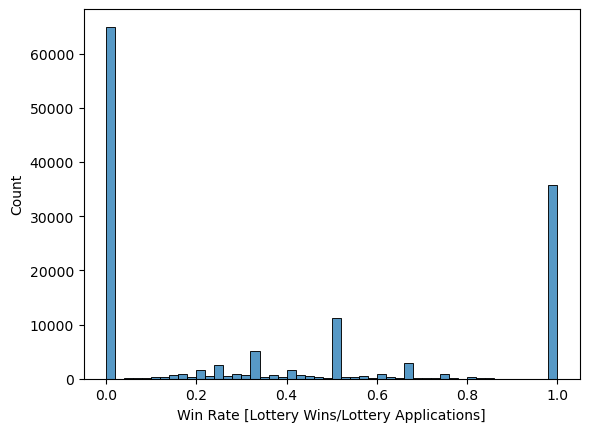

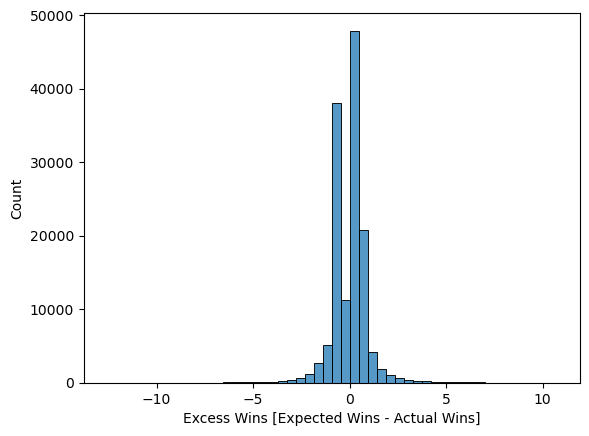

In [21]:
# histogram of win rate; excess wins
df_wins = insamp.groupby(['FEIN','lottery_year']).agg(n_apps = pd.NamedAgg(column = 'employer_name', aggfunc = 'count'), n_wins = pd.NamedAgg(column = 'win', aggfunc = 'sum')).reset_index()
df_wins['winrate'] = df_wins['n_wins']/df_wins['n_apps']
df_wins['p'] = df_wins.groupby('lottery_year').transform('sum')['n_wins']/df_wins.groupby('lottery_year').transform('sum')['n_apps']
df_wins['excess_wins'] = df_wins['n_apps']*df_wins['p']-df_wins['n_wins']

sns.histplot(data = df_wins, x = 'winrate', bins = 50).set(xlabel = "Win Rate [Lottery Wins/Lottery Applications]")
plt.figure()
sns.histplot(data = df_wins, x = 'excess_wins', bins = 50).set(xlabel = "Excess Wins [Expected Wins - Actual Wins]")

In [22]:
df_wins.groupby('lottery_year')['excess_wins'].mean()

lottery_year
2021    5.214459e-17
2022   -7.403422e-17
2023    1.357739e-17
2024   -8.137724e-17
Name: excess_wins, dtype: float64

[Text(0.5, 0, 'Age at Application'),
 Text(0, 0.5, 'Share of FY2023 Non-Duplicate Winners/Losers'),
 (18.0, 65.0)]

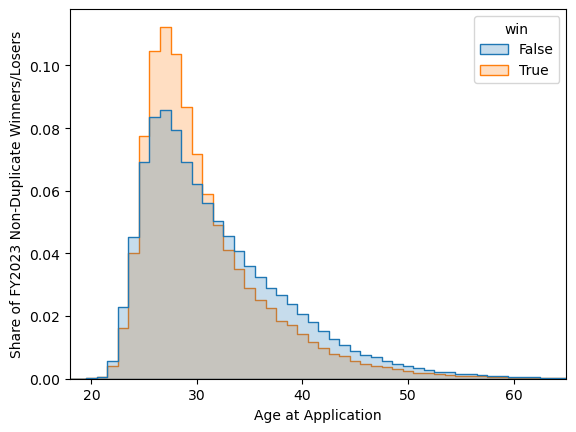

In [23]:
# histogram of birth year
sns.histplot(data = insamp, x = 'app_age', hue = 'win', discrete = True, element = "step", stat = "proportion", common_norm = False).set(xlabel = "Age at Application", ylabel = "Share of FY2023 Non-Duplicate Winners/Losers", xlim = (18,65))

/var/folders/6z/xpll6gz5179770l_wm4h0_fc0000gn/T/ipykernel_40497/4167392539.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/6z/xpll6gz5179770l_wm4h0_fc0000gn/T/ipykernel_40497/4167392539.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[Text(0.5, 0, 'Reported US Employment')]

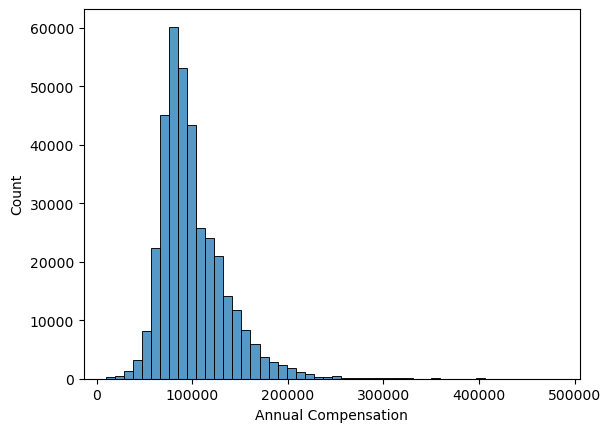

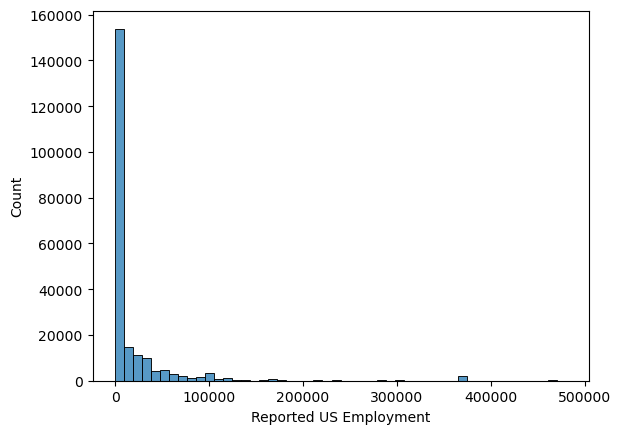

In [25]:
winners = foia_df.loc[(foia_df['win']==1)&(foia_df['BEN_COMP_PAID'] != 'NA')&(foia_df['NUM_OF_EMP_IN_US'] != 'NA')]
winners['BEN_COMP_PAID'] = winners['BEN_COMP_PAID'].apply(float)
winners['nemp'] = winners['NUM_OF_EMP_IN_US'].apply(int)

sns.histplot(data = winners.loc[(winners['BEN_COMP_PAID'] > 10000) & (winners['BEN_COMP_PAID'] < 500000)], x = 'BEN_COMP_PAID', bins = 50).set(xlabel="Annual Compensation")

plt.figure()
sns.histplot(data = winners.loc[(winners['nemp'] > 0) & (winners['nemp'] < 500000)], x = 'nemp', bins=50).set(xlabel='Reported US Employment')

## Merging with Revelio Data

In [26]:
df_byemp = foia_df.groupby(['FEIN','lottery_year','matchind','sampgroup']).agg(n_apps = pd.NamedAgg(column = 'employer_name', aggfunc = 'count'), n_wins = pd.NamedAgg(column = 'win', aggfunc = 'sum')).reset_index()

df_byemp['winrate'] = df_byemp['n_wins']/df_byemp['n_apps']
df_byemp['p'] = df_byemp.groupby('lottery_year').transform('sum')['n_wins']/df_byemp.groupby('lottery_year').transform('sum')['n_apps']
df_byemp['excess_wins'] = df_byemp['n_apps']*df_byemp['p']-df_byemp['n_wins']

df_byemp.groupby(['matchind','sampgroup']).size()

print(f"Overall Match Rate: {round(100*df_byemp.loc[df_byemp['matchind'] == 1].shape[0]/df_byemp.shape[0])}%")
print(f"Preferred Sample Rate: {round(100*df_byemp.loc[(df_byemp['matchind'] == 1)&(df_byemp['sampgroup'] == 'insamp')].shape[0]/df_byemp.loc[df_byemp['sampgroup'] == 'insamp'].shape[0])}%")
print(f"Out of Sample Rate: {round(100*df_byemp.loc[(df_byemp['matchind'] == 1)&(df_byemp['sampgroup'] == 'outsamp')].shape[0]/df_byemp.loc[df_byemp['sampgroup'] == 'outsamp'].shape[0])}%")

Overall Match Rate: 64%
Preferred Sample Rate: 66%
Out of Sample Rate: 56%


<Axes: xlabel='Excess Wins [Expected Wins - Actual Wins]', ylabel='Proportion'>

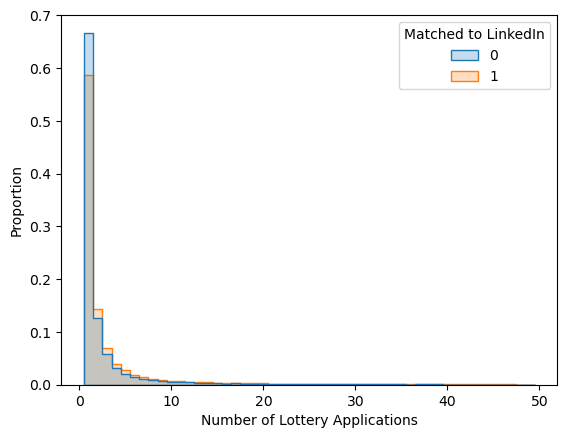

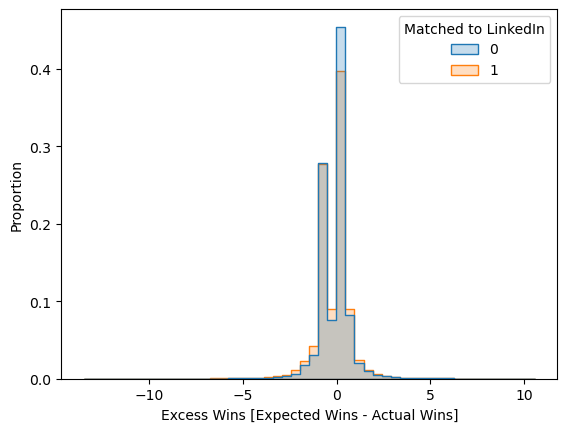

In [27]:
df_byemp_ps = df_byemp.loc[df_byemp['sampgroup']=='insamp']
a= sns.histplot(data = df_byemp_ps, x = "n_apps", hue = "matchind",element = "step", stat = "proportion", common_norm = False, discrete = True)
a.set(xlabel = 'Number of Lottery Applications')
a.legend_.set(title = "Matched to LinkedIn")
a
plt.figure()

b=sns.histplot(data = df_byemp_ps, x = "excess_wins", hue = "matchind", bins = 50, element = "step", stat = "proportion", common_norm = False)
b.set(xlabel = 'Excess Wins [Expected Wins - Actual Wins]')
b.legend_.set(title = "Matched to LinkedIn")
b

In [28]:
# mean diffs
print(df_byemp_ps.groupby('matchind')['n_apps'].mean())
print(stats.ttest_ind(df_byemp_ps.loc[df_byemp_ps['matchind']== 0]['n_apps'],df_byemp_ps.loc[df_byemp_ps['matchind']== 1]['n_apps']))

print(df_byemp_ps.groupby('matchind')['excess_wins'].mean())
print(stats.ttest_ind(df_byemp_ps.loc[df_byemp_ps['matchind']== 0]['excess_wins'],df_byemp_ps.loc[df_byemp_ps['matchind']== 1]['excess_wins']))

matchind
0    2.668186
1    3.337682
Name: n_apps, dtype: float64
TtestResult(statistic=-21.37346101300979, pvalue=3.446340078240276e-101, df=138045.0)
matchind
0   -0.019401
1   -0.074605
Name: excess_wins, dtype: float64
TtestResult(statistic=10.437510757950776, pvalue=1.7083224021636307e-25, df=138045.0)


## First Stage Results

In [29]:
balanced_full = con.read_parquet(f"{root}/data/int/balanced_full_mar25.parquet")

fs_joined = con.sql("SELECT a.FEIN AS FEIN, a.lottery_year::FLOAT AS ly, t::FLOAT AS t, n_apps_tot AS n_apps, n_success_tot AS n_wins, n_i129, n_appr, sampgroup FROM (balanced_full AS a JOIN (SELECT FEIN, lottery_year, sampgroup FROM foia_main_samp_def) AS b ON a.FEIN = b.FEIN AND a.lottery_year = b.lottery_year)")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────────┐
│ count(DISTINCT FEIN) │
│        int64         │
├──────────────────────┤
│                 1135 │
└──────────────────────┘



/var/folders/6z/xpll6gz5179770l_wm4h0_fc0000gn/T/ipykernel_40497/62380041.py:7: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



[None]

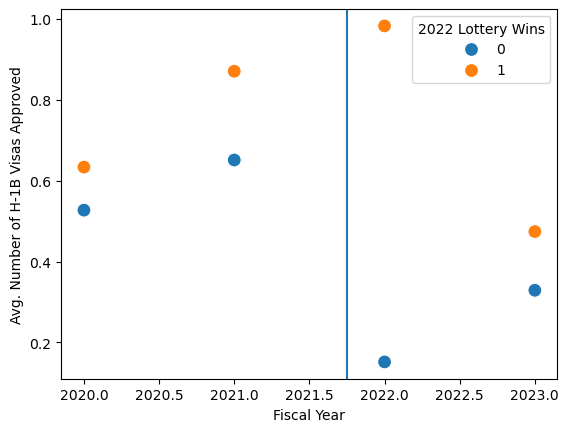

In [30]:
# single win
fs_collapsed = con.sql("SELECT ly, t, n_wins::VARCHAR AS n_wins, MEAN(CASE WHEN n_appr IS NULL THEN 0 ELSE n_appr END) AS mean_appr FROM fs_joined WHERE n_apps = 1 AND sampgroup = 'insamp' AND ly = 2023 AND t < 2024 GROUP BY n_wins, ly, t").df()

print(con.sql("SELECT COUNT(DISTINCT FEIN) FROM fs_joined WHERE n_apps = 1 AND sampgroup = 'insamp' AND ly = 2023 "))
#print(fs_collapsed)
pivot_long = fs_collapsed.pivot(index = ['t','ly'], columns = ['n_wins'], values = ['mean_appr'])
pivot_long = pivot_long.join(pivot_long.groupby(level = 0, axis = 1).diff().rename(columns={'1':'diff'}).loc(axis = 1)[:,'diff']).reset_index().melt(id_vars = [('t',''),('ly','')])

pivot_long.columns = ['t', 'ly', 'var', 'treat', 'value']

rawvars = pivot_long.loc[pivot_long['treat'] != 'diff']
diffs = pivot_long.loc[pivot_long['treat'] == 'diff']

out = sns.scatterplot(data = rawvars, x = 't', y = 'value', hue = 'treat', s = 100)
out.axvline(x = 2021.75)
out.set(xlabel = "Fiscal Year", ylabel = "Avg. Number of H-1B Visas Approved")
out.legend_.set(title = "2022 Lottery Wins")


In [122]:
samp_to_foia_id = con.sql("SELECT * FROM ((SELECT FEIN, lottery_year, sampgroup FROM foia_main_samp_def) AS a JOIN (SELECT FEIN, lottery_year, foia_id FROM foia_with_ids GROUP BY FEIN, lottery_year, foia_id) AS b ON a.FEIN = b.FEIN AND a.lottery_year = b.lottery_year) WHERE foia_id IS NOT NULL")

out_joined = con.sql("SELECT a.foia_id AS foia_id, main_rcid, a.lottery_year::FLOAT AS ly, t::FLOAT AS t, n_apps_tot AS n_apps, n_success_tot AS n_wins, new_positions, new_hires, n_emp, sampgroup FROM (merged_for_analysis AS a JOIN (SELECT foia_id, sampgroup FROM samp_to_foia_id) AS b ON a.foia_id = b.foia_id)")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────────────┐
│ count(DISTINCT foia_id) │
│          int64          │
├─────────────────────────┤
│                   13758 │
└─────────────────────────┘



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      1389558 │
└──────────────┘



/var/folders/6z/xpll6gz5179770l_wm4h0_fc0000gn/T/ipykernel_60991/2165577964.py:11: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pivot_long = pivot_long.join(pivot_long.groupby(level = 0, axis = 1).diff().rename(columns={'1':'diff'}).loc(axis = 1)[:,'diff']).reset_index().melt(id_vars = [('t',''),('ly','')])


[None]

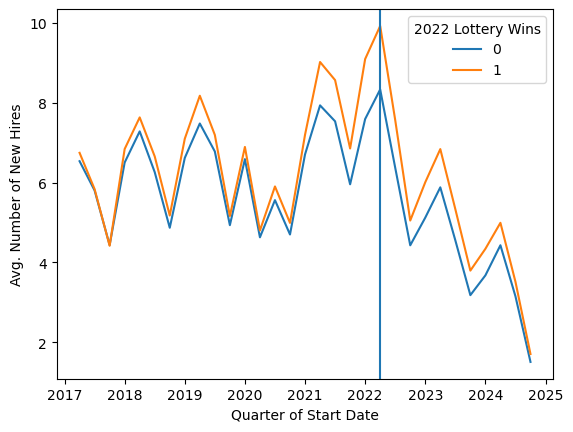

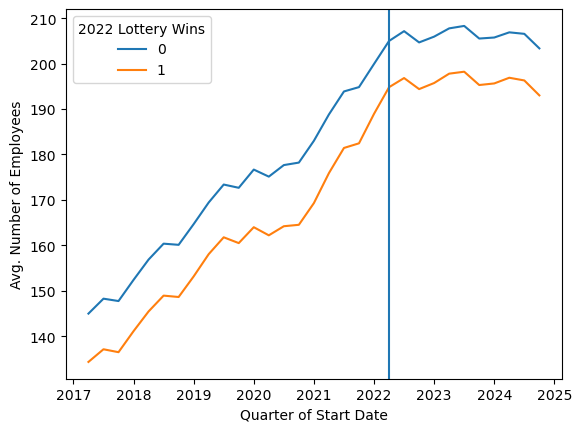

In [123]:
# single win
lotyear = 2023
out_collapsed = con.sql(f"SELECT ly, t, n_wins::VARCHAR AS n_wins, MEAN(CASE WHEN new_hires IS NULL THEN 0 ELSE new_hires END) AS mean_new_hires, MEAN(new_hires) AS mean_new_hires_nulls, MEAN(CASE WHEN n_emp IS NULL THEN 0 ELSE n_emp END) AS mean_n_emp, MEAN(n_emp) AS mean_n_emp_nulls FROM out_joined WHERE n_apps = 1 AND sampgroup = 'insamp' AND ly = {lotyear} AND t < 2025 AND t > 2017 GROUP BY n_wins, ly, t").df()

print(con.sql(f"SELECT COUNT(DISTINCT foia_id) FROM out_joined WHERE n_apps = 1 AND sampgroup = 'insamp' AND ly = {lotyear}"))
#print(fs_collapsed)
print(con.sql(f"SELECT COUNT(*) FROM out_joined WHERE n_apps = 1 AND sampgroup = 'insamp' AND ly = {lotyear}"))
# TODO: GET BALANCED SAMPLE?

pivot_long = out_collapsed.pivot(index = ['t','ly'], columns = ['n_wins'], values = ['mean_new_hires','mean_n_emp','mean_new_hires_nulls','mean_n_emp_nulls'])
pivot_long = pivot_long.join(pivot_long.groupby(level = 0, axis = 1).diff().rename(columns={'1':'diff'}).loc(axis = 1)[:,'diff']).reset_index().melt(id_vars = [('t',''),('ly','')])

pivot_long.columns = ['t', 'ly', 'var', 'treat', 'value']

rawvars = pivot_long.loc[pivot_long['treat'] != 'diff']
diffs = pivot_long.loc[pivot_long['treat'] == 'diff']

out = sns.lineplot(data = rawvars.loc[rawvars['var']=='mean_new_hires'], x = 't', y = 'value', hue = 'treat')
out.axvline(x = lotyear-0.75)
out.set(xlabel = "Quarter of Start Date", ylabel = "Avg. Number of New Hires")
out.legend_.set(title = f"{lotyear-1} Lottery Wins")

plt.figure()
out2 = sns.lineplot(data = rawvars.loc[rawvars['var']=='mean_n_emp'], x = 't', y = 'value', hue = 'treat')
out2.axvline(x = lotyear-0.75)
out2.set(xlabel = "Quarter of Start Date", ylabel = "Avg. Number of Employees")
out2.legend_.set(title = f"{lotyear - 1} Lottery Wins")

[None]

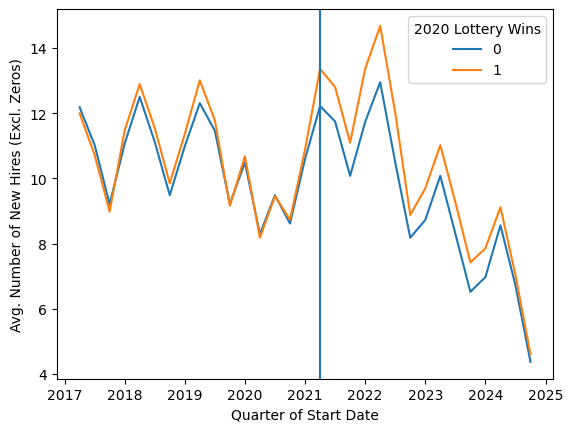

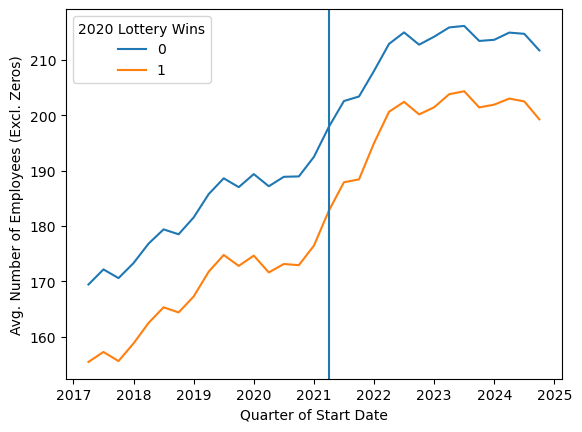

In [33]:
out = sns.lineplot(data = rawvars.loc[rawvars['var']=='mean_new_hires_nulls'], x = 't', y = 'value', hue = 'treat')
out.axvline(x = 2021.25)
out.set(xlabel = "Quarter of Start Date", ylabel = "Avg. Number of New Hires (Excl. Zeros)")
out.legend_.set(title = "2020 Lottery Wins")

plt.figure()
out2 = sns.lineplot(data = rawvars.loc[rawvars['var']=='mean_n_emp_nulls'], x = 't', y = 'value', hue = 'treat')
out2.axvline(x = 2021.25)
out2.set(xlabel = "Quarter of Start Date", ylabel = "Avg. Number of Employees (Excl. Zeros)")
out2.legend_.set(title = "2020 Lottery Wins")

## Exploring Individual Companies

In [91]:
#samp = con.sql("SELECT *, COUNT(CASE WHEN ) AS nwins FROM (SELECT * FROM foia_with_ids")


samp_to_foia_id_test = con.sql("SELECT * FROM ((SELECT FEIN, lottery_year, sampgroup FROM foia_main_samp_def) AS a JOIN (SELECT * FROM foia_with_ids) AS b ON a.FEIN = b.FEIN AND a.lottery_year = b.lottery_year) WHERE foia_id IS NOT NULL")


test1 = con.sql("SELECT a.foia_id AS foia_id, main_rcid, a.lottery_year::FLOAT AS ly, t::FLOAT AS t, n_apps_tot AS n_apps, n_success_tot AS n_wins, new_hires::FLOAT AS new_hires, n_emp::FLOAT AS n_emp, sampgroup, BEN_CURRENT_CLASS, REQUESTED_ACTION, S3Q1, ben_country_of_birth FROM (merged_for_analysis AS a JOIN (SELECT * FROM samp_to_foia_id_test) AS b ON a.foia_id = b.foia_id)")

samp = con.sql("SELECT * FROM test1 WHERE REQUESTED_ACTION = 'A' AND n_wins < 3 AND sampgroup = 'insamp' AND new_hires IS NOT NULL AND n_emp > 10 AND n_emp < 200 AND t = 2021 AND ly = 2022").df()
print(samp.shape)
samp.sample(n=10)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(820, 13)


,foia_id,main_rcid,ly,t,n_apps,n_wins,new_hires,n_emp,sampgroup,BEN_CURRENT_CLASS,REQUESTED_ACTION,S3Q1,BEN_COUNTRY_OF_BIRTH
662,10083,213839,2022.0,2021.0,4,2,2.0,57.0,insamp,F1,A,B,INDIA
271,31627,709188,2022.0,2021.0,2,1,3.0,54.0,insamp,UU,A,B,PAKIS
104,81822,7870112,2022.0,2021.0,1,1,5.0,67.0,insamp,UU,A,M,INDIA
478,12198,261850,2022.0,2021.0,4,1,2.0,37.0,insamp,UU,A,B,INDIA
286,71943,4849865,2022.0,2021.0,2,1,1.0,44.0,insamp,NA,A,B,UK
149,26706,593493,2022.0,2021.0,1,1,3.0,84.0,insamp,UU,A,B,UK
42,29968,669788,2022.0,2021.0,1,1,1.0,12.0,insamp,UU,A,B,INDIA
48,100211,81426051,2022.0,2021.0,1,1,0.0,30.0,insamp,NA,A,B,INDIA
358,62232,1631252,2022.0,2021.0,7,2,0.0,166.0,insamp,UU,A,B,INDIA
225,22993,505379,2022.0,2021.0,2,1,3.0,99.0,insamp,TN2,A,B,MEXIC


In [ ]:
# test_foia_id = 45917
# test_rcid = 1048230

# test_foia_id = 32595
# test_rcid = 732750

# test_foia_id = 80486
# test_rcid = 7683540

# test_foia_id = 81822
# test_rcid = 7870112

test_foia_id = 10083
test_rcid = 213839

foia_raw = con.sql(f"SELECT * FROM foia_with_ids WHERE foia_id = {test_foia_id}").df()
test_fein = foia_raw['FEIN'][0] 
foia_raw_all = con.sql(f"SELECT * FROM foia_with_ids WHERE FEIN = '{test_fein}'").df()
#foia_raw_all.groupby('lottery_year').size().reset_index()
foia_raw_all

,bcn,country_of_birth,country_of_nationality,ben_date_of_birth,ben_year_of_birth,gender,employer_name,FEIN,mail_addr,city,...,S3Q1,S4Q1,T_U_VAWA_FLAG,state_name,worksite_state_name,lottery_year_1,FEIN_1,foia_id,matched,matchind
0,(b)(6),CHN,CHN,(b)(6),1996,female,Bay Area Compliance Laboratories Corp.,770442546,1274 Anvilwood Ave,Sunnyvale,...,NA,NA,NA,California,NA,2023,770442546,10084,1,1
1,(b)(6),CHN,CHN,(b)(6),1997,male,Bay Area Compliance Laboratories Corp.,770442546,1274 Anvilwood Avenue,Sunnyvale,...,NA,NA,NA,California,NA,2024,770442546,10085,1,1
2,(b)(6),CHN,CHN,(b)(6),1996,female,Bay Area Compliance Laboratories Corp.,770442546,1274 Anvilwood Avenue,Sunnyvale,...,NA,NA,NA,California,NA,2024,770442546,10085,1,1
3,(b)(6),IDN,IDN,(b)(6),1995,male,Bay Area Compliance Laboratories Corp.,770442546,1274 Anvilwood Ave,Sunnyvale,...,NA,NA,NA,California,NA,2023,770442546,10084,1,1
4,(b)(6),IDN,IDN,(b)(6),1995,male,Bay Area Compliance Laboratories Corp.,770442546,1274 Anvilwood Ave,Sunnyvale,...,NA,NA,NA,California,NA,2021,770442546,10082,1,1
5,(b)(6),IND,IND,(b)(6),1993,male,Bay Area Compliance Laboratories Corp.,770442546,1274 Anvilwood Ave,Sunnyvale,...,B,N,NA,California,California,2022,770442546,10083,1,1
6,(b)(6),IDN,IDN,(b)(6),1995,male,Bay Area Compliance Laboratories Corp.,770442546,1274 Anvilwood Ave,Sunnyvale,...,NA,NA,NA,California,NA,2022,770442546,10083,1,1
7,(b)(6),MYS,MYS,(b)(6),1982,male,Bay Area Compliance Laboratories Corp.,770442546,1274 Anvilwood Avenue,Sunnyvale,...,NA,NA,NA,California,NA,2024,770442546,10085,1,1
8,(b)(6),CHN,CHN,(b)(6),1996,female,Bay Area Compliance Laboratories Corp.,770442546,1274 Anvilwood Ave,Sunnyvale,...,NA,NA,NA,California,NA,2021,770442546,10082,1,1
9,(b)(6),CHN,CHN,(b)(6),1994,male,Bay Area Compliance Laboratories Corp.,770442546,1274 Anvilwood Ave,Sunnyvale,...,M,N,NA,California,California,2022,770442546,10083,1,1


In [112]:
con.sql(f"SELECT * FROM merged_for_analysis WHERE foia_id = {test_foia_id}").df()

,lottery_year,main_rcid,foia_id,company_FOIA,n_us_employees,n_apps_tot,n_apps,n_success_tot,n_success,n_i129,t,new_positions,new_hires,n_emp
0,2022,213839,10083,Bay Area Compliance Laboratories Corp.,0,4,4,2,2,2,2017.50,4,3,50
1,2022,213839,10083,Bay Area Compliance Laboratories Corp.,0,4,4,2,2,2,2014.00,4,4,30
2,2022,213839,10083,Bay Area Compliance Laboratories Corp.,0,4,4,2,2,2,2017.00,7,6,50
3,2022,213839,10083,Bay Area Compliance Laboratories Corp.,0,4,4,2,2,2,2006.00,3,3,9
4,2022,213839,10083,Bay Area Compliance Laboratories Corp.,0,4,4,2,2,2,2012.00,<NA>,<NA>,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,2022,213839,10083,Bay Area Compliance Laboratories Corp.,0,4,4,2,2,2,2008.50,1,1,10
97,2022,213839,10083,Bay Area Compliance Laboratories Corp.,0,4,4,2,2,2,2025.00,<NA>,<NA>,60
98,2022,213839,10083,Bay Area Compliance Laboratories Corp.,0,4,4,2,2,2,2005.00,1,1,6
99,2022,213839,10083,Bay Area Compliance Laboratories Corp.,0,4,4,2,2,2,2012.25,<NA>,<NA>,15


In [113]:
# getting revelio data (merging positions to user to education)
import wrds 
db = wrds.Connection(wrds_username='amykimecon')


Loading library list...
Done


In [105]:

company_info = db.raw_sql(f"SELECT * FROM revelio.company_mapping WHERE rcid = {test_rcid}")
year_founded = int(company_info['year_founded'][0])
company_info

,rcid,company,factset_entity_id,year_founded,ticker,exchange_name,sedol,isin,cusip,url,...,hq_metro_area,hq_state,hq_country,hq_region,rics_k50,rics_k200,rics_k400,phone_number,slogan,description
0,213839.0,Bay Area Compliance Laboratories Corp.,081P8W-E,1996,<NA>,<NA>,<NA>,<NA>,<NA>,baclcorp.com,...,san jose metropolitan area (california),California,United States,Northern America,Engineering and Construction Services,Engineering and Technology Services,Engineering and Technology Services,<NA>,Let's protect the world together. We shape the...,"Since 1996, Bay Area Compliance Laboratories C..."


In [106]:
test = db.raw_sql(f"SELECT a.user_id AS user_id, a.position_id AS a, country, state, metro_area, a.startdate AS pos_startdate, a.enddate AS pos_enddate, role_k1500, weight, start_salary, end_salary, seniority, salary, position_number, rcid, total_compensation, fullname, highest_degree, sex_predicted, ethnicity_predicted, user_location, user_country, updated_dt, university_name, c.education_number, c.startdate AS ed_startdate, c.enddate AS ed_enddate, degree, field, university_country, title_raw, university_raw, degree_raw, field_raw FROM (SELECT * FROM revelio.individual_positions WHERE rcid = {test_rcid}) AS a LEFT JOIN (SELECT * FROM revelio.individual_user) AS b ON a.user_id = b.user_id LEFT JOIN (SELECT * FROM revelio.individual_user_education) AS c ON a.user_id = c.user_id LEFT JOIN (SELECT position_id, company_raw, location_raw, title_raw, description FROM revelio.individual_positions_raw) AS d ON a.position_id = d.position_id LEFT JOIN (SELECT * FROM revelio.individual_user_education_raw) AS e ON c.user_id = e.user_id AND c.education_number=e.education_number")
test.shape


(436, 34)

In [110]:

test['firststart'] = test.groupby('user_id').transform('min')['pos_startdate']
test['hs'] = test['degree_raw'].str.lower().str.contains('high school')
test['ed_startyear'] = test.apply(lambda x: None if pd.isnull(x.ed_startdate) or (pd.isnull(x.hs) == 0 and x.hs == 1) else (None if int(x.ed_startdate[:4]) < 1950 else int(x.ed_startdate[:4])), axis = 1)

test['est_yob'] = test.groupby('user_id')['ed_startyear'].transform('min') - 18
#sns.histplot(data = test, x = 'est_yob')
test['firststartyear'] = test['firststart'].apply(lambda x: None if pd.isnull(x) else int(x[:4]))
print(test.shape)
# test.loc[(test['firststartyear'] >= year_founded)&(test['country']=='United States')].sort_values(['firststart','user_id'])[['fullname', 'est_yob', 'title_raw', 'role_k1500', 'pos_startdate', 'pos_enddate', 'state','metro_area','degree_raw','field_raw','university_raw','university_country','ed_startdate','ed_enddate','user_id']]
test.loc[(test['firststartyear'] >= year_founded)&(test['country']=='United States')&(test['fullname'] == "Di Li")].sort_values(['firststart','user_id'])[['fullname', 'est_yob', 'title_raw', 'role_k1500', 'pos_startdate', 'pos_enddate', 'state','metro_area','degree_raw','field_raw','university_raw','university_country','ed_startdate','ed_enddate','user_id']]

(436, 39)


,fullname,est_yob,title_raw,role_k1500,pos_startdate,pos_enddate,state,metro_area,degree_raw,field_raw,university_raw,university_country,ed_startdate,ed_enddate,user_id
298,Di Li,1990.0,RF/EMC Engineer,electronics engineer,2017-08-01,2019-03-01,California,san jose metropolitan area (california),Bachelor's degree,Communication Engineering,Harbin Institute of Technology,China,2008-01-01,2012-01-01,633586358.0
299,Di Li,1990.0,RF/EMC Engineer,electronics engineer,2017-08-01,2019-03-01,California,san jose metropolitan area (california),Master's degree,Electrical,University of Massachusetts Dartmouth,United States,2013-01-01,2016-01-01,633586358.0


In [108]:
test.groupby('university_raw').size().reset_index()

,university_raw,0
0,Abraham Lincoln High,1
1,Afghan Institute of Technology,2
2,Australian International School,1
3,Balboa High School,1
4,Beijing Union University,1
...,...,...
215,聖約翰科技大學,1
216,西安翻译学院,2
217,长安大学,1
218,长春理工大学,2


In [ ]:
test_user_id = 4205215.0
testuser_positions = db.raw_sql(f"SELECT a.user_id AS user_id, b.position_id AS pos_id, country, state, metro_area, b.startdate AS pos_startdate, b.enddate AS pos_enddate, role_k1500, weight, start_salary, end_salary, seniority, salary, position_number, b.rcid AS rcid, company, total_compensation, fullname, highest_degree, sex_predicted, ethnicity_predicted, user_location, user_country, updated_dt, title_raw FROM (SELECT * FROM revelio.individual_user WHERE user_id = {test_user_id}) AS a LEFT JOIN (SELECT * FROM revelio.individual_positions) AS b ON a.user_id = b.user_id LEFT JOIN (SELECT position_id, company_raw, location_raw, title_raw, description FROM revelio.individual_positions_raw) AS d ON b.position_id = d.position_id LEFT JOIN (SELECT rcid, company FROM revelio.company_mapping) AS f ON b.rcid = f.rcid")

testuser_positions[['country','state','metro_area','title_raw','company','pos_startdate','pos_enddate','salary']]

,country,state,metro_area,title_raw,company,pos_startdate,pos_enddate,salary
0,United States,Massachusetts,boston metropolitan area,Graduate Research Assistant,The Trustees of Columbia University in The Cit...,2019-08-01,2020-05-01,59380.65
1,United States,Massachusetts,boston metropolitan area,Graduate Tutor,The Trustees of Columbia University in The Cit...,2019-09-01,2020-04-01,67227.4
2,United States,Massachusetts,boston metropolitan area,Examinations Proctor,The Trustees of Columbia University in The Cit...,2019-10-01,2020-04-01,67855.35
3,United States,Massachusetts,boston metropolitan area,Member,The Trustees of Columbia University in The Cit...,2019-10-01,2020-05-01,106178.66
4,United States,Massachusetts,boston metropolitan area,Communications Lead,The Trustees of Columbia University in The Cit...,2019-10-01,2019-12-01,56374.0
5,United States,Massachusetts,boston metropolitan area,President: Columbia Engineering Energy Club (C...,The Trustees of Columbia University in The Cit...,2020-01-01,2020-12-01,204810.74
6,United States,Massachusetts,boston metropolitan area,Member: Omega Chi Epsilon Honor Society,The Trustees of Columbia University in The Cit...,2021-01-01,2022-05-01,103780.21
7,United States,New York,new york city metropolitan area,Materials Intern,"Folia Water, Inc.",2020-05-01,2020-08-01,38654.43
8,United States,Massachusetts,boston metropolitan area,Chemical Engineer,"Folia Water, Inc.",2020-09-01,2020-12-01,96631.74
9,United States,Massachusetts,boston metropolitan area,Chemical Engineer,"Folia Water, Inc.",2021-01-01,2022-05-01,109548.08


In [ ]:
testuser_educ = db.raw_sql(f"SELECT a.user_id AS user_id, fullname, highest_degree, sex_predicted, ethnicity_predicted, user_location, user_country, updated_dt, university_name, c.education_number, c.startdate AS ed_startdate, c.enddate AS ed_enddate, degree, field, university_country, university_raw, degree_raw, field_raw FROM (SELECT * FROM revelio.individual_user WHERE user_id = {test_user_id}) AS a LEFT JOIN (SELECT * FROM revelio.individual_user_education) AS c ON a.user_id = c.user_id LEFT JOIN (SELECT * FROM revelio.individual_user_education_raw) AS e ON c.user_id = e.user_id AND c.education_number=e.education_number")

testuser_educ[['fullname','']]


,rcid,company,factset_entity_id,year_founded,ticker,exchange_name,sedol,isin,cusip,url,...,hq_metro_area,hq_state,hq_country,hq_region,rics_k50,rics_k200,rics_k400,phone_number,slogan,description
0,732750.0,"Folia Water, Inc.",0HM5VY-E,2016,<NA>,<NA>,<NA>,<NA>,<NA>,foliamaterials.com,...,pittsburgh metropolitan area,Pennsylvania,United States,Northern America,Wellness Products,Home Goods and Personal Care Products,Home Goods and Personal Care Products,<NA>,Folia Materials: advanced materials inside mas...,"Folis is making a safer, cleaner, and healthie..."
